# Relative Overgeneralisation environment

In [2]:
import numpy as np
import random

class RelOvergenEnv:

    def __init__(self, state_dim, 
                 optim_reward=8, optim_diff_coeff=25, 
                 suboptim_reward=0, suboptim_diff_coeff=0.125):
        self.obs_dim = state_dim
        self.act_dim = 2

        self.state_dim = state_dim
        self.unit = 10.0 / state_dim
        self.states = list(np.arange(0.0, 10.0, self.unit))

        self.agents_pos = [0, 0]

        self.optimal_state = [
            int(state_dim / 5) * self.unit, 
            int(state_dim / 6) * self.unit]
        self.suboptimal_state = [
            10.0 - self.optimal_state[0], 
            10.0 - self.optimal_state[1]]
        
        self.optim_reward = optim_reward
        self.optim_diff_coeff = optim_diff_coeff
        self.suboptim_reward = suboptim_reward
        self.suboptim_diff_coeff = suboptim_diff_coeff
        
        self.max_steps = state_dim
        self.current_step = 0

    def get_obs(self):
        return [
            np.eye(self.state_dim)[self.agents_pos[0]],
            np.eye(self.state_dim)[self.agents_pos[1]]
        ]

    def reset(self):
        for a_i in range(2):
            self.agents_pos[a_i] = random.randint(0, self.state_dim - 1)
        self.current_step = 0
        return self.get_obs()

    def compute_reward(self):
        opti = self.optim_reward - self.optim_diff_coeff * (
            (self.states[self.agents_pos[0]] - self.optimal_state[0]) ** 2 + 
            (self.states[self.agents_pos[1]] - self.optimal_state[1]) ** 2)
        subopti = self.suboptim_reward - self.suboptim_diff_coeff * (
            (self.states[self.agents_pos[0]] - self.suboptimal_state[0]) ** 2 + 
            (self.states[self.agents_pos[1]] - self.suboptimal_state[1]) ** 2)
        return max(opti, subopti)

    def step(self, actions):
        for a_i in range(2):
            self.agents_pos[a_i] += int(actions[a_i][0])
            self.agents_pos[a_i] -= int(actions[a_i][1])
            if self.agents_pos[a_i] < 0:
                self.agents_pos[a_i] = 0
            elif self.agents_pos[a_i] >= self.state_dim:
                self.agents_pos[a_i] = self.state_dim - 1
        next_states = self.get_obs()

        reward = self.compute_reward()
        rewards =[reward, reward]
        
        self.current_step += 1
        done = float(self.current_step >= self.max_steps)
        dones = [done, done]
        
        return next_states, rewards, dones, None
    
    def close(self):
        pass

## Plotting the reward function

In [3]:
def get_reward_function(env):
    reward = np.zeros((env.state_dim, env.state_dim))
    for i in range(env.state_dim):
        for j in range(env.state_dim):
            env.agents_pos = [i, j]
            reward[i, j] = env.compute_reward()
    return reward

<Axes: >

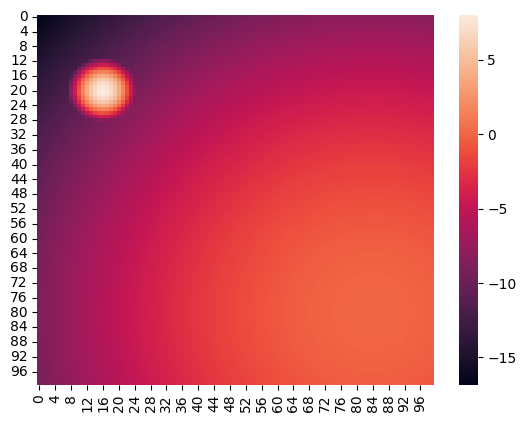

In [4]:
import seaborn as sns

env = RelOvergenEnv(100, 8, 25, 0, 0.125)
reward = get_reward_function(env)
sns.heatmap(reward)

<AxesSubplot:>

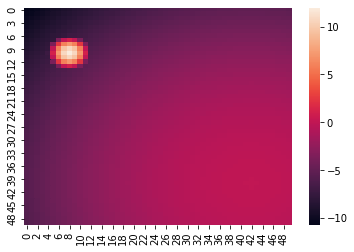

In [6]:
env = RelOvergenEnv(50, 12, 30, 0, 0.08)
reward = get_reward_function(env)
sns.heatmap(reward)

<AxesSubplot:>

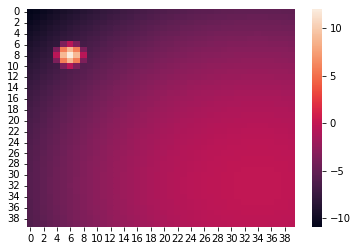

In [10]:
env = RelOvergenEnv(40, 12, 50, 0, 0.08)
reward = get_reward_function(env)
sns.heatmap(reward)

<AxesSubplot:>

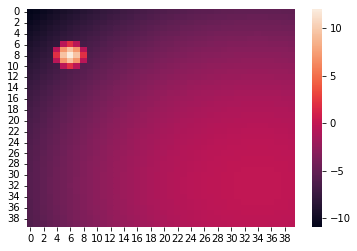

In [9]:
env = RelOvergenEnv(40, 12, 40, 0, 0.08)
reward = get_reward_function(env)
sns.heatmap(reward)

<AxesSubplot:>

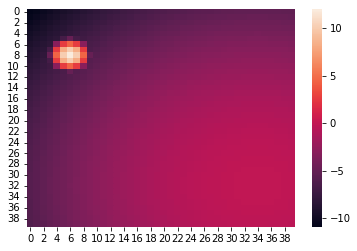

In [4]:
env = RelOvergenEnv(40, 12, 30, 0, 0.08)
reward = get_reward_function(env)
sns.heatmap(reward)

<AxesSubplot:>

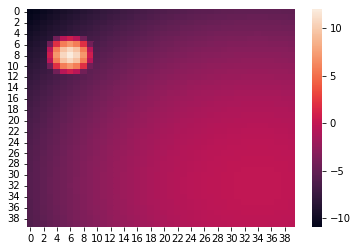

In [5]:
env = RelOvergenEnv(40, 12, 20, 0, 0.08)
reward = get_reward_function(env)
sns.heatmap(reward)

<AxesSubplot:>

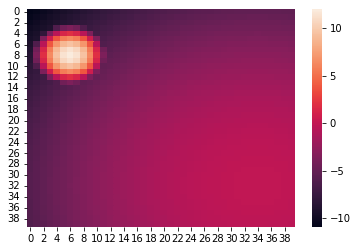

In [6]:
env = RelOvergenEnv(40, 12, 10, 0, 0.08)
reward = get_reward_function(env)
sns.heatmap(reward)

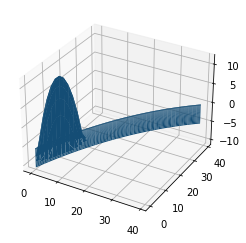

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
ax.plot_surface(list(range(40)), list(range(40)), reward)

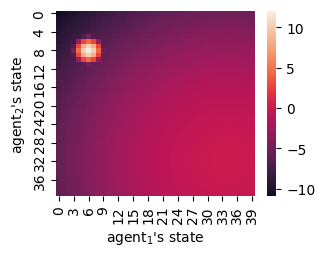

In [6]:
import matplotlib.pyplot as plt
env = RelOvergenEnv(40, 12, 30, 0, 0.08)
reward = get_reward_function(env)
fig, ax = plt.subplots(figsize=(3.2,2.4))  
s = sns.heatmap(reward, center=0, cmap=sns.cm.rocket, ax=ax)
s.set(xlabel=r"agent$_1$'s state", ylabel=r"agent$_2$'s state")
plt.savefig("ro_map.jpg", dpi=500, bbox_inches='tight')

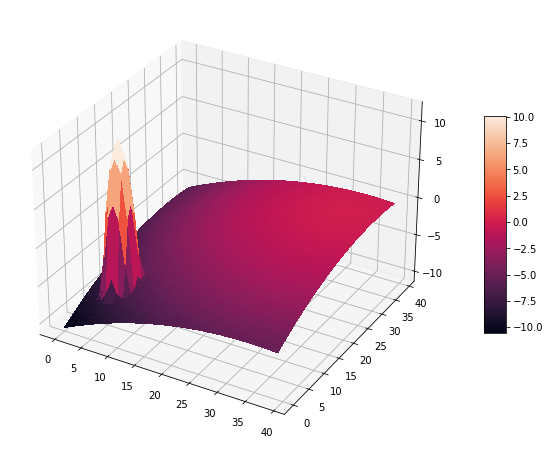

In [22]:
import matplotlib.pyplot as plt
from matplotlib import cm

fig, ax = plt.subplots(subplot_kw=dict(projection='3d'), figsize=(15, 8))
X = np.arange(0, 40, 1)
Y = np.arange(0, 40, 1)
X, Y = np.meshgrid(X, Y)
hm = ax.plot_surface(X, Y, reward, cmap=sns.cm.rocket, antialiased=False)
fig.colorbar(hm, shrink=0.5, aspect=10)

## Plotting learnt Q-values

In [12]:
import torch

def get_q_tot(obs, model):
    init_last_actions, init_hidden_states = model.get_init_model_inputs()
    values = []
    for a_i in range(len(obs)):
        q_values, _ = model.agents[a_i].get_q_values(
            obs[a_i], 
            init_last_actions[a_i],
            init_hidden_states[a_i])
        values.append(float(q_values.max()))
    values = torch.Tensor(values).view(1, 1, -1)
    state = torch.cat(obs, dim=-1).unsqueeze(0)
    q_tot = model.mixer(values, state)
    return float(q_tot)

def get_q_function(model):
    value_fn = np.zeros((model.obs_dim, model.obs_dim))
    for i in range(model.obs_dim):
        for j in range(model.obs_dim):
            obs = [
                torch.Tensor([np.eye(model.obs_dim)[i]]),
                torch.Tensor([np.eye(model.obs_dim)[j]])
            ]
            value_fn[i, j] = get_q_tot(obs, model)
    return value_fn

/tmp/ipykernel_60071/965710976.py:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  torch.Tensor([np.eye(model.obs_dim)[i]]),


<AxesSubplot:>

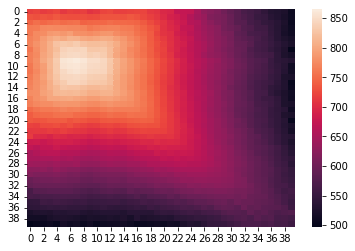

In [13]:
from model.modules.qmix import QMIX

model = QMIX.init_from_save("../../models/rel_overgen/qmix/run3/model.pt")
model.prep_rollouts()
value = get_q_function(model)
sns.heatmap(value)

<AxesSubplot:>

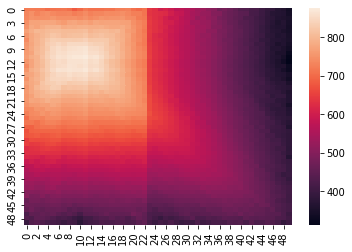

In [95]:
from model.modules.qmix_noveld import QMIX_MANovelD

model = QMIX_MANovelD.init_from_save("../../models/rel_overgen/qmix_manoveld_fo/run8/model.pt")
model.prep_rollouts()
value = get_q_function(model)
sns.heatmap(value)

<AxesSubplot:>

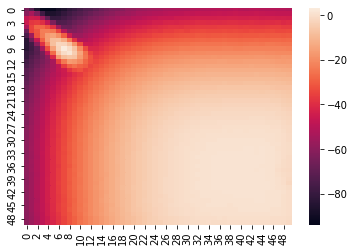

In [96]:
from model.modules.qmix import QMIX

model = QMIX.init_from_save("../../models/rel_overgen/qmix_fo/run10/model.pt")
model.prep_rollouts()
value = get_q_function(model)
sns.heatmap(value)

<AxesSubplot:>

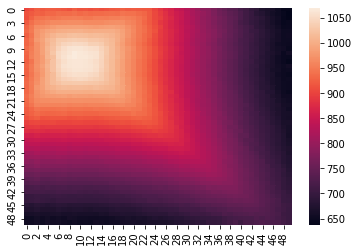

In [97]:
model = QMIX_MANovelD.init_from_save("../../models/rel_overgen/qmix_manoveld_fo/run6/model.pt")
model.prep_rollouts()
value = get_q_function(model)
sns.heatmap(value)

<AxesSubplot:>

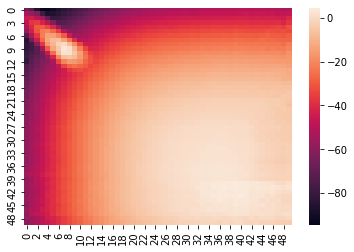

In [98]:
model = QMIX.init_from_save("../../models/rel_overgen/qmix_fo/run5/model.pt")
model.prep_rollouts()
value = get_q_function(model)
sns.heatmap(value)

# Plotting exploration of states

In [45]:
import os
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def get_visit_map(run):
    vm = np.zeros((40,40))
    for s in run:
        vm[s[0], s[1]] += 1
    return vm

def get_visited_states(dir_path):
    vms = []
    for f in os.listdir(dir_path):
        if f[-5:] == ".json":
            print(f)
            with open(os.path.join(dir_path, f)) as f:
                vs = json.load(f)
            vms.append(np.log(get_visit_map(vs)))
    return vms

visited_states copy 8.json
visited_states copy 11.json
visited_states copy 6.json
visited_states copy 12.json
visited_states.json
visited_states copy 13.json
visited_states copy 4.json
visited_states copy.json
visited_states copy 2.json
visited_states copy 7.json
visited_states copy 14.json
visited_states copy 10.json
visited_states copy 5.json
visited_states copy 3.json
visited_states copy 9.json


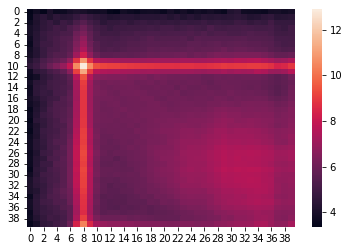

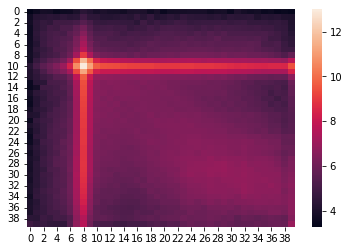

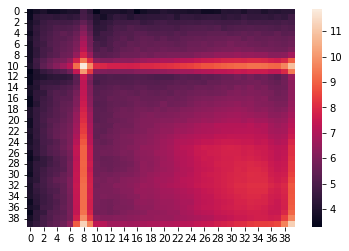

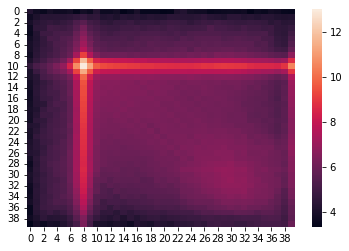

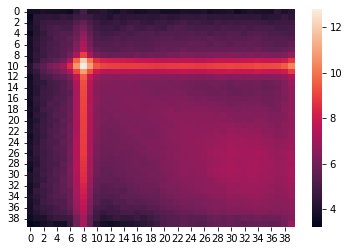

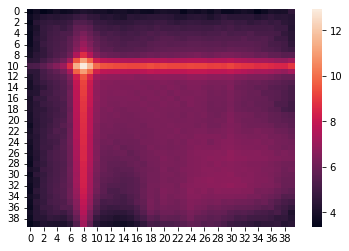

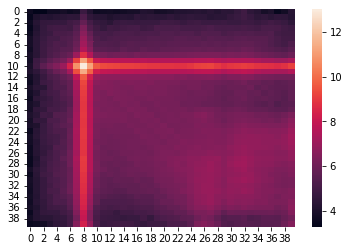

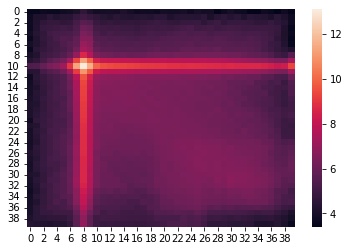

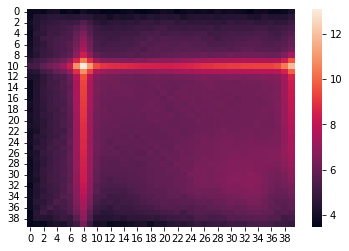

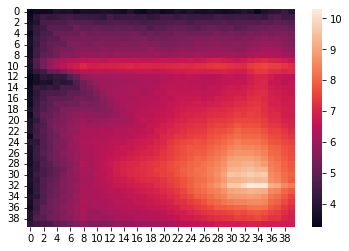

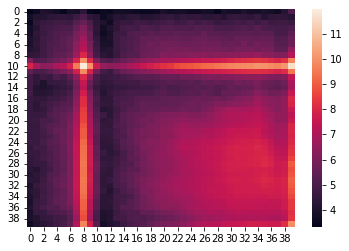

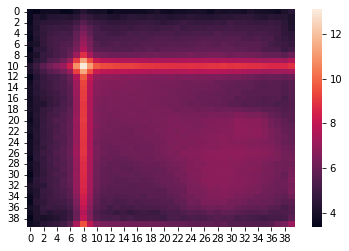

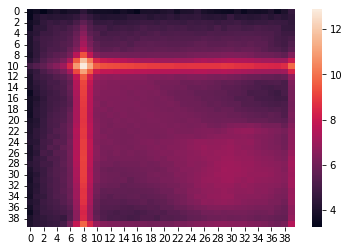

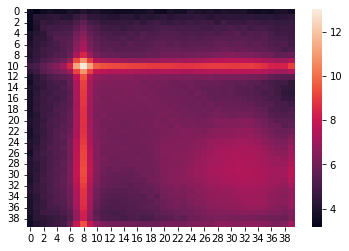

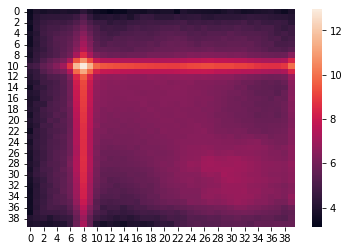

In [46]:
vms = get_visited_states("../../models/rel_overgen/qmix_cent_e2snoveld_inv_dyn/train_data_4030")

for vm in vms:
    sns.heatmap(vm)
    plt.show()

vs_run11.json
vs_run6.json
vs_run13.json
vs_run4.json
vs_run15.json
vs_run1.json
vs_run16.json
vs_run5.json
vs_run2.json
vs_run7.json
vs_run9.json
vs_run17.json
vs_run19.json
vs_run18.json
vs_run3.json


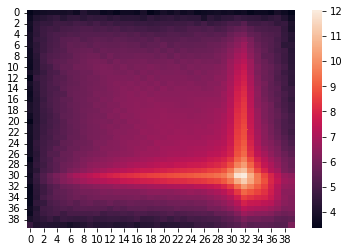

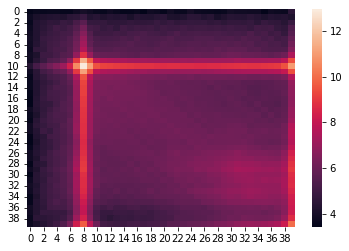

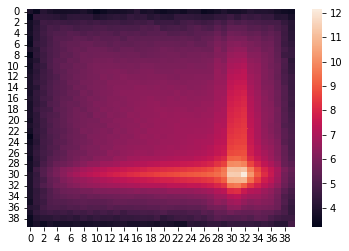

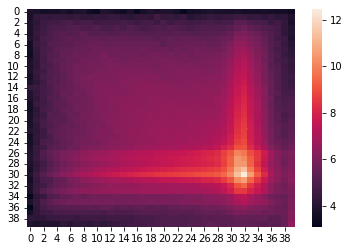

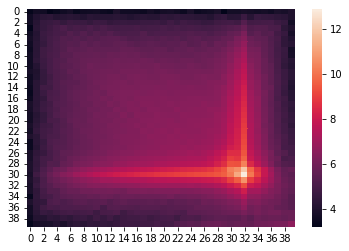

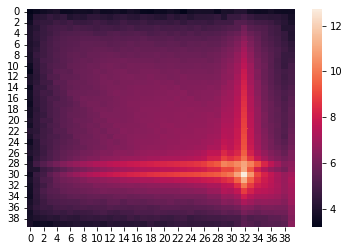

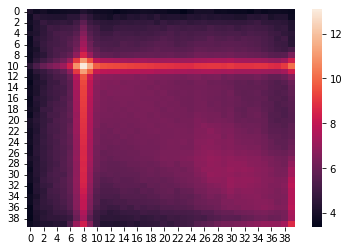

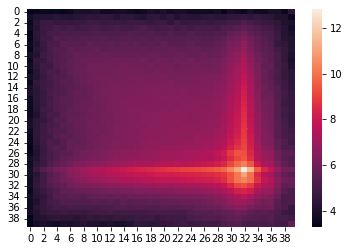

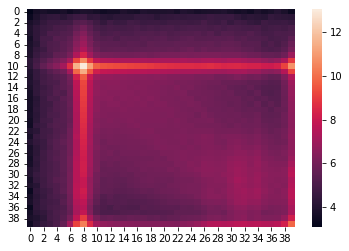

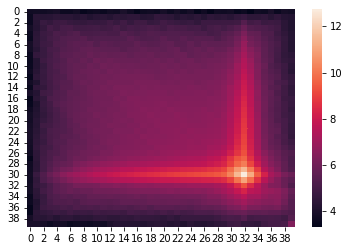

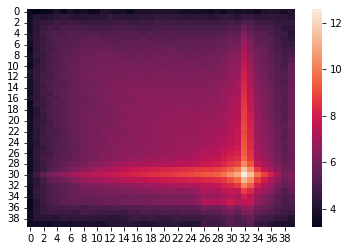

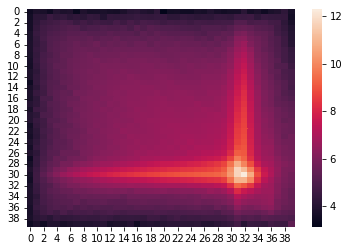

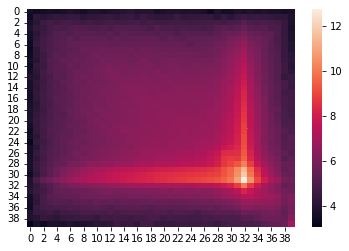

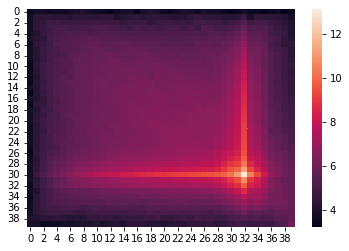

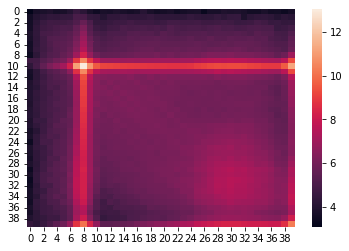

In [48]:
loc_vms = get_visited_states("../../models/rel_overgen/qmix_loc_e2snoveld_inv_dyn/train_data_4030")

for vm in loc_vms:
    sns.heatmap(vm)
    plt.show()

visited_states.json


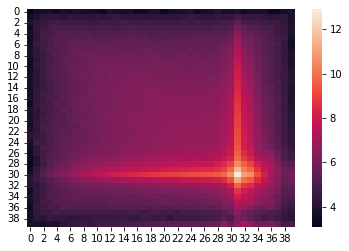

In [49]:
none_vms = get_visited_states("../../models/rel_overgen/qmix/train_data_40_30")

for vm in none_vms:
    sns.heatmap(vm)
    plt.show()

In [42]:
all_vms = np.array(vms)


(15, 40, 40)

<AxesSubplot:>

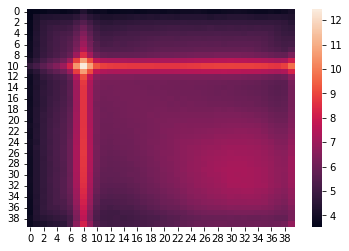

In [51]:
mean_vms = np.mean(vms, axis=0)
sns.heatmap(mean_vms)

In [25]:
vs_n = get_visited_states("../../models/rel_overgen/qmix/train_data_40_30")
len(vs_n[0])

visited_states.json


2050000

In [31]:
from IPython import display

for i in range(40,100000,8000):
    vm = get_visit_map(vs[1][:i])
    display.clear_output(wait=True)
    sns.heatmap(vm)
    plt.show()

IndexError: list index out of range

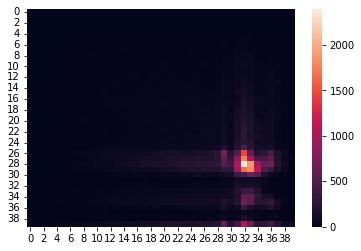

In [26]:
for i in range(40,100000,4000):
    vm = get_visit_map(vs_n[0][:i])
    display.clear_output(wait=True)
    sns.heatmap(vm)
    plt.show()

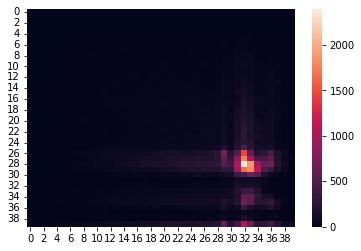

In [30]:
vs_l = get_visited_states("../../models/rel_overgen/qmix_loc_e2snoveld_inv_dyn/train_data_4030")
for i in range(40,100000,8000):
    vm = get_visit_map(vs_n[0][:i])
    display.clear_output(wait=True)
    sns.heatmap(vm)
    plt.show()

In [35]:
vms

[array([[  31.,   44.,   32., ...,   52.,   45.,   50.],
        [  33.,   68.,   86., ...,   76.,   77.,   85.],
        [  41.,   65.,   95., ...,  112.,  114.,  113.],
        ...,
        [  39.,   87.,  122., ...,  718.,  707.,  717.],
        [  41.,   73.,  106., ...,  690.,  648.,  816.],
        [  34.,   52.,   98., ...,  828.,  861., 1413.]]),
 array([[  27.,   37.,   47., ...,   32.,   35.,   32.],
        [  41.,   72.,   74., ...,   74.,   62.,   58.],
        [  43.,   81.,  103., ...,  102.,   94.,   60.],
        ...,
        [  52.,   94.,  108., ...,  597.,  505.,  769.],
        [  81.,   78.,  123., ...,  359.,  321.,  660.],
        [ 128.,  100.,  116., ...,  371.,  353., 1057.]]),
 array([[3.2000e+01, 4.4000e+01, 5.3000e+01, ..., 6.2000e+01, 7.1000e+01,
         7.1000e+01],
        [3.5000e+01, 7.5000e+01, 8.3000e+01, ..., 9.6000e+01, 8.4000e+01,
         1.1700e+02],
        [4.6000e+01, 6.8000e+01, 1.0200e+02, ..., 1.2300e+02, 1.4200e+02,
         1.3200e+02]